## Progetto Cerrito - Riconoscimento e Classificazione celllule malate di malaria

Import delle librerie necessarie al funzionamento del codice:

In [1]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
from keras import backend as K
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as imgplt
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from PIL import Image
import matplotlib.transforms as mtransforms
import shap
import itertools
import lime
from lime import lime_image

Using TensorFlow backend.


# Parametri del modello

1. __train_data_dir__ ------------> La directory che contiene il dataset che utilizzeremo per fare in train del modello.
2. __validation_data_dir__ -------> La directory contenente il dataset per la valutazione del modello (alcune immagini su cui faremo delle previsioni)
3. __img_width, img_height__ -----> le dimensioni delle immagini con cui faremo lavorare il modello (rescaling delle stesse)
4. __nb_train_samples__ ----------> dimensione dei campioni che si vogliono utilizzare nel training
5. __nb_validation_samples__ -----> numero di campioni che si vogliono utilizzare durante in test del modello
6. __epochs__ --------------------> numero di epochs con cui faremo il training del modello
7. __batch_size__ ----------------> numero di campioni che utilizzeremo per ogni singolo passo di training (weights adjustment)

In [26]:
out = widgets.Output(layout={'border': '1px solid black'})
out.append_stdout("Son")
train_data_dir = os.path.join('cell_images', 'Dataset')

print("Directory relativa del dataset: ", train_data_dir)

img_width, img_height = 64, 64
nb_train_samples = 3000
nb_validation_samples = 990
epochs = 50
batch_size = 16

Directory relativa del dataset:  cell_images/Dataset


# Modello della rete neurale

Impostiamo la forma di input (shape) verificando se dipende o no dal backend __image_data_format__, per uniformare la lettura delle immagini.

Inizializziamo il modello inserendo __Sequential()__ che ci permette di inserire in maniera sequenziale più livelli ordinati dall'input all'output.


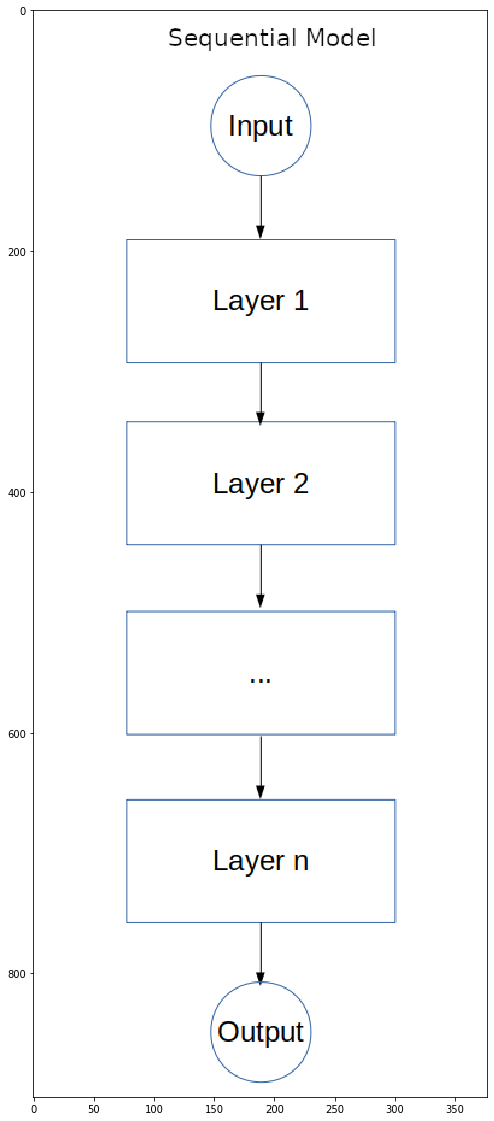

In [27]:
img = Image.open('doc_images/sequential_model.png')
plt.figure(figsize = (12, 20)) 
plt.imshow(img)

In [28]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()

## 1. Rete Convoluzionale
A seguito, aggiungiamo un layer convoluzionale 2D, per analizzare le immagini in input. come possiamo vedere dalla figura sottostante, vi sono k kernels che vengono applicate all'immagine, che producono alla fine un output 2D, detta mappa di attivazione. 

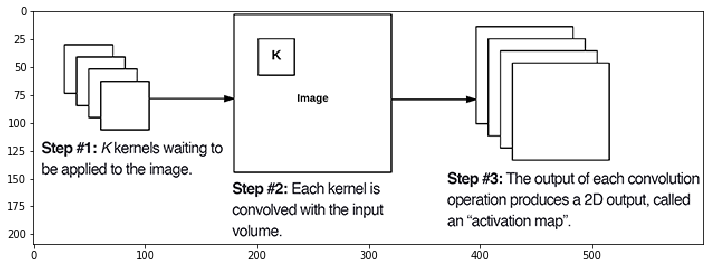

In [29]:
img = Image.open('doc_images/conv2d.png')
plt.figure(figsize = (12, 20)) 
plt.imshow(img)

La necessità sara impostare più layer Conv2D affinchè la rete possa funzionare al meglio. Infatti, tra i parametri necessari di Conv2D vi è il numero di filtri che dovrà calcolare. I primi layer nell'architettura (i layer più vicini alle immagini di input), apprendono pochi filtri, ma man mano che ci addentriamo in profondità nella network (cioè man mano che ci avviciniamo all'output) i filtri appresi saranno sempre di più.

Ora per far funzionare la network impostiamo i parametri:

1. Impostiamo il numero di canali in output della Conv2D (nel primo layer a 32)
2. Passiamo anche la kernel_size (cioè una 3x3 window che si muove sull'immagine) e i passi in avanti (strides) nelle direzioni x e y (1, 1).
3. Impostiamo la funzione di attivazione a "relu: rectified linear unit", impostiamo anche la forma di input (input shape) calcolata prima. L'input shape è necessario specificarlo solo per il primo livello.

NOTA:
Con il parametro strides  impostato a (1, 1), un filtro convoluzionale viene applicato alla posizione corrente dell'immagine, il filtro fa un passo a destra, si applica, e va avanti finchè non raggiunge il bordo destro dell'immagine. A questo punto il filtro fa un passo in basso di un pixel e ricomincia da sinistra verso destra. Il vantaggio di utilizzare un strides basso, è che l'apprendimento sarà migliore, visto che verrà fatta una analisi pixel per pixel, lo svantaggio è la mole enorme di di dati prodotti in output. 
Vedremo più avanti come ridurrre l'output.


In [30]:
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))

Il parametro __activation__ permette di indicare quale funzione di attivazione sarà applicata dopo la convoluzione. Utilizzeremo la funzione definita "relu".

Citando la documentazione di Keras, relu è cosi definita:

_* With default values, it returns element-wise max(x, 0). *_

_*Otherwise, it follows: f(x) = maxvalue for x >= maxvalue, f(x) = x for threshold <= x < maxvalue, f(x) = negativeslope  (x - threshold) otherwise. *_



Le funzioni possibili sono riportate nell'immagine sottostante:

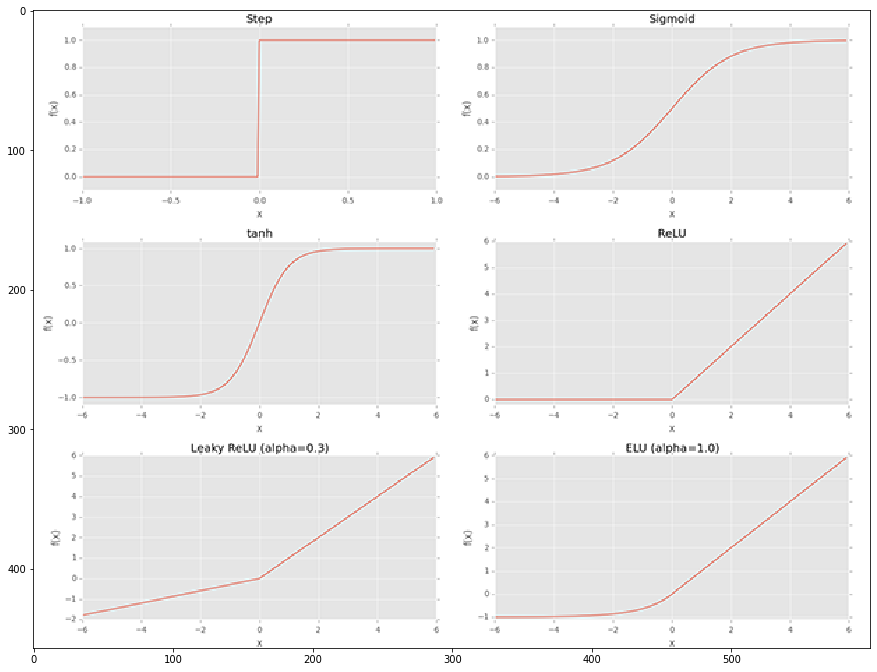

In [31]:
img = Image.open('doc_images/activation_function.png')
plt.figure(figsize = (15, 15)) 
plt.imshow(img)

A seguito aggiungiamo al modello un 2D max pooling layer.

Nella funzione __MaxPooling2D()__ definiamola dimensione del pooling (2, 2) ed i passi in avanit (strides) nelle direzioni x e y (2, 2).

La funzione Max pooling  viene utilizzata per ridurre le dimensioni spaziali del output di Conv2D.

Nelle architetture CNN è prassi fare questo passaggio, infatti anche se riduciamo le dimensioni dell'output, man mano che procediamo aumenta il numero di filtri appresi.

In [32]:
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

Evolvendo il modello, aggiungiamo ancora due layer Conv2D con output a 32 canali e MaxPooling2D per ridurre.

In [33]:
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

A seguito aggiungiamo ancora una conv2d con 64 canali di output e MaxPooling2D per ridurre.

In [34]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

## 2. Dense layer (fully connected)
Adesso che nella rete i layer convoluzionali sono stati aggiunti ed abbiamo gli output, vogliamo connettere questi ultimi a dei livelli full connected. 
Per poter connettere una rete full connected (Dense Layers) alla rete di convoluzione, abbiamo la necessità di rendere un tensore multidimensionale uno ad 1 dimensione. Questa operazione viene fatta dalla funzione __Flatten()__.  

Aggiungiamo due layers __Dense()__ (completamente connessi) impostando per la prima 64 outpute e funzione di attivazione relu, la sencoda Dense con output 1 e funzione di attivazione sigmoid (vogliamo fare un riconoscimento binario, visto che la classificazione è su due classi).
Intercaliamo tra i due layer Dense, la funzione __Dropout__, utilizzata per impostare casualmente una percentuale (0.5) di unità di input a 0 ad ogni aggiornamento del training, utile per prevenire ulteriormente l'overfitting.

Per esempio, se l'output del layer convoluzionale è nella forma (15, 3, 3, 4), flatten "unstacks" (modifica appiattendo) tutti i valori del tensore in un tensore 1-D del tipo (15\*3\*3\*4,) così da poter essere utilizzato com input della Dense.

In [35]:
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

Last step of our model definition is the __model.compile()__
here we need to pass some arguments:
1. the loss function we want to minimize (keras provides a lot of loss functions - see [here](https://keras.io/losses/))
2. an optimizer function to optimize our learning process (keras provides also a lot of loss functions - see [here](https://keras.io/optimizers/))
3. a metric for the model evaluation. (as before keras provides a lot of loss functions - see [here](https://keras.io/metrics/))

In [36]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Preparazione dei dati per la rete


Per convenzione vengono assegnate le seguenti label, a partire dalla directory di input:
1. unifected = 0
2. parasitized = 1

Applichiamo un split del dataset in per creare il dataset di test che corrisponde al 20% del dataset completo, applichiamo una seconda divisione del train set dividendolo al 50% tra train e validation, utilizzeremo il validation set per verificare il buon funzionamento della network in fase di predict.

In [37]:
data = []
uninfected = os.listdir(train_data_dir+"/Uninfected")
parasitized = os.listdir(train_data_dir+"/Parasitized")

for i in uninfected:
    data.append([train_data_dir+"/Uninfected/"+i,'Uninfected'])
for i in parasitized:
    data.append([train_data_dir+"/Parasitized/"+i,'Parasitized'])
random.shuffle(data)
image = [i[0] for i in data]
label = [i[1] for i in data]
del data

X_train, X_test, Y_train, Y_test = train_test_split(image, label, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.5, random_state=46)


Keras permette di utilizzare la classe __ImageDataGenerator()__ per generare un nuovo dataflow a partire da una directory su filesystem per generare l'input del nostro modello di training. Inoltre vi sono funzioni che ci permettono di randomizzare e manipolare le immagini prima di caricarle come input del modello, permettendo di fare un training più accurato.

Infatti faremo in modo che le immagini subiscano queste trasformazioni, in maniera tale che il modello non venda due volte di seguito la stessa immagine. Ciò permetterà di evitare (o almeno ridurre drasticamente) l'overfitting del modello. Inoltre il modello risultante sarà più generalizzato.

I parametri impostati sono:

* __rotation_range__ valore in gradi compreso tra 0 e 180°, con il quale il modello ruoterà randomicamente le immagini.
* __width_shift__ e __height_shift__ intervalli dati come frazioni delle dimensioni totali di cui il modello transla orizzontalmente e verticalmente le immagini randomicamente.
* __rescale__  è un valore con cui saranno riscalati i dati in input prima di qualsiasi altro prcoesso. Le immagini originali consistono in coefficienti RGB dati come valori tra 0 e 255, ma tali valori sono troppo alti per il modello, per cui li riscaliamo in maniera che siano compresi tra 0 e 1 .
* __shear_range__ percentuale di applicazione di funzioni di taglio randomiche
* __zoom_range__ percentuale di applicazioni di funzioni di zoom randomiche.
* __horizontal_flip__  per capovolgere metà delle immagini orizzontalmente, vale a dire quando non ci sono assunzioni di asimmetria orizzontale (ad esempio nel caso di immagini reali)
* __fill_mode__ è la funzione utilizzata per generare i pixel che potrebbero essere creati dalla funzione di rotazione o dalla translazione.

In [38]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

## Caricamento immagini da una directory (e relative sottodirectory)

Generiamo dei dataframe per avere una tabella Filename e Label associata, a partire dai dataset generati in precendenza, ricordiamo che X_train sono le immagini, Y_train le label associate, così anche per la parte test e validation.



In [39]:
x_train_dataframe = pd.DataFrame({'Filename':X_train, 'Label':Y_train})
x_testval_dataframe = pd.DataFrame({'Filename':X_test, 'Label':Y_test})
x_validation_dataframe = pd.DataFrame({'Filename':X_val, 'Label':Y_val})

x_train_dataframe.head(4)

,Filename,Label
0,cell_images/Dataset/Uninfected/C37BP2_thinF_IM...,Uninfected
1,cell_images/Dataset/Parasitized/C132P93ThinF_I...,Parasitized
2,cell_images/Dataset/Uninfected/C77P38ThinF_IMG...,Uninfected
3,cell_images/Dataset/Uninfected/C56P17thinF_IMG...,Uninfected


## Training e test generator

Kera per mette di creare e caricare le immagini direttamente a partire dai dataframe, tramite l'uso dei generator. Nel caso specifico, utilizziamo la funzione __flow_from_dataframe__, passando anche i parametri batch_size e le dimensioni a cui riscalare le immagini.

Il parametro __directory__ viene posto a None, visto che nell'X_train e nel X_test sono già specificati i percorsi per ogni immagine.

In [40]:
X_train_generator = train_datagen.flow_from_dataframe(dataframe = x_train_dataframe,directory = None, x_col = 'Filename', y_col = 'Label', class_mode = 'binary', batch_size = batch_size, target_size=(img_width, img_height))
X_testval_generator = train_datagen.flow_from_dataframe(dataframe = x_testval_dataframe,directory = None, x_col = 'Filename', y_col = 'Label', class_mode = 'binary', batch_size = batch_size, target_size=(img_width, img_height))

Found 11023 validated image filenames belonging to 2 classes.
Found 5512 validated image filenames belonging to 2 classes.


# Modello Generato

Utilizzando la funzione __summary__, possiamo vedere un riassunto della network generata secondo il modello impostato.

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
__________

# Libreria SHAP

Utilizziamo la libreria SHAP per avere una visione migliore del modello, utilizzando l'explainer __DeepExplainer__, analizzando il modello con 200 elementi del train dataset e 20 explanations.

In [42]:
#codice per generator

## Training del modello

A questo punto verifichiamo l'esistenza dei file __malaria_weights.h5__, __malaria_model_trained__ e __validation_dataframe.csv__, in tal caso li carichiamo, altrimenti passiamo a fare il training della rete.

Avendo utilizzato i generator di keras, il training sarà fatto tramite la funzione __fit_generator__, con i parametri:

1. Il training dataset
2. __step_per_epoch__ i passi necessari per ogni epoch, che sarà il numero di campioni di training diviso la dimensione di batch.
3. __epochs__ il numero di epoch con cui vagliamo fare il training del modello.
4. __validation_data__ il dataset di test per validare il modello.
5. __validation_steps__ i passi necessari per ogni epoch per la validazione, che sarà il numero di campioni di test diviso la dimensione di batch.


In [43]:
savemod = 1
if os.path.exists('malaria_weights.h5') and os.path.exists('malaria_model_trained.mod') and os.path.exists('validation_dataframe.csv'):
    history = load_model('malaria_model_trained.mod')
    history.load_weights('malaria_weights.h5')
    x_validation_dataframe = pd.read_csv('validation_dataframe.csv')
    savemod = 0

else:
    history = model.fit_generator(
        X_train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=X_testval_generator,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
187/187 [==============================] - 55s 295ms/step - loss: 0.7020 - acc: 0.5060 - val_loss: 0.6948 - val_acc: 0.4928
Epoch 2/50
187/187 [==============================] - 52s 277ms/step - loss: 0.6506 - acc: 0.6464 - val_loss: 0.5851 - val_acc: 0.6814
Epoch 3/50
187/187 [==============================] - 51s 275ms/step - loss: 0.4659 - acc: 0.8025 - val_loss: 0.3529 - val_acc: 0.8627
Epoch 4/50
187/187 [==============================] - 51s 272ms/step - loss: 0.3397 - acc: 0.8639 - val_loss: 0.3651 - val_acc: 0.8402
Epoch 5/50
187/187 [==============================] - 51s 270ms/step - loss: 0.3290 - acc: 0.8783 - val_loss: 0.2977 - val_acc: 0.9068
Epoch 6/50
187/187 [==============================] - 50s 270ms/step - loss: 0.3062 - acc: 0.8937 - val_loss: 0.3179 - val_acc: 0.8781
Epoch 7/50
187/187 [==============================] - 51s 272ms/step - loss: 0.3013 - acc: 0.8964 - val_loss: 0.2638 - val_acc: 0.9160
Epoch 8/50
187/187 [==============================] - 5

# Validità del modello
## 1. Informazioni loss e accuracy
Valutiamo il modello mediante la funzione __evaluate_generator__, necessaria quando si utilizzano i generator di Keras, utilizzando il dataset di test (Validation), per verificare i valori di loss e accuracy:

In [44]:
step_size_testval = X_testval_generator.n // batch_size
score=model.evaluate_generator(generator=X_testval_generator,steps=step_size_testval, verbose=0)
print('Loss sul dataset di test:', score[0])
print('Accuracy sul dataset di test:', score[1])


Loss sul dataset di test: 0.280184844348802
Accuracy sul dataset di test: 0.9215793304221251


## 2. Plot del grafico
Salvando il processo di training, abbiamo la possibilità di poter stampare le metriche in un grafico. Osservando il grafico, si nota già che circa dopo solo 10 epochs, il modello sale  a circa il 90% di accuracy sul dataset di training e su quello di testing. Si noto anche che sul dataset di test l'accuracy non è delle migliori, ma manteniamo il modello in queste circostanze, per evitare di avere overfitting sui dati. Infatti se guardiamo al test accuracy, otteniamo un solo 50%.
Potremmo migliorare aoncora il modello, cambiando la seconda Conv2D in maniera che prenda 64 input, la terza Conv2D ne prenda 128, così potremmo utilizzare le immagini ridimensionate a 128px, aumentare anche il numero di epochs, ma in tal modo il tempo di training aumenta in maniera esponenziale. Avendo a disposizione una macchina non tra le migliori per poter eseguire processi di Machine Learning, accettiamo il compromesso scelto, che comunque da ottimi risultati.

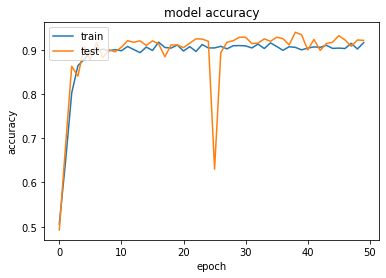

In [45]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Salvataggio del modello

Per non dover rifare il training ogni volta che eseguiamo il codice, è buona norma salvare il modello già pronto, da poterlo riutilizzare in qualsiasi momento. Per cui:

1. Salviamo i pesi risultanti del modello (weights) senza salvare l'architettura. (utile se vogliamo per esempio spostare il modello su un divero framework)
2. Salviamo l'intero modello, così che keras è in grado di caricarlo ed utilizzarlo.
3. Salviamo __x_validation_dataframe__ su csv, in questo modo possiamo tener traccia del dataset di validation, cioè le immagini che abbiamo escludo dal dataset di training e di test, quando abbiamo inizializzato il modello. (se cancelliamo il modello salvato, i pesi e il csv, il modello viene reinizializzato, ma i dataset di training, test e validation vengono generati in maniera casuale, per cui saranno sempre diversi)


In [46]:
# Save weights for further use
if savemod:
    model.save_weights('malaria_weights.h5')
    model.save('malaria_model_trained.mod')
    x_validation_dataframe.to_csv('validation_dataframe.csv')

# Fit sui dati di validation
Il nostro modello a questo punto è pronto a fare anche le previsioni su delle immagini che non ha mai "visto", per cui verifichiamo il buon funzionamento. Avendo generato un dataset di validazione, lo utilizziamo per fare fit. Stampiamo i risultati, avendo nel dataset anche le etichette associate alle immagini (Uninfected, Parasized), calcoliamo quanti falsi positivi (cellule uninfected riconosciute come malate, caso meno grave) e quanti falsi negativi (cellule malate riconosciute come non infette; caso più grave). Visto il numero alto di immagini, la stampa richiede un pò di tempo, per velocizzare, possiamo anche decommentare la __if.....break__ per avere il grafico sulle prime 1000 istanze.

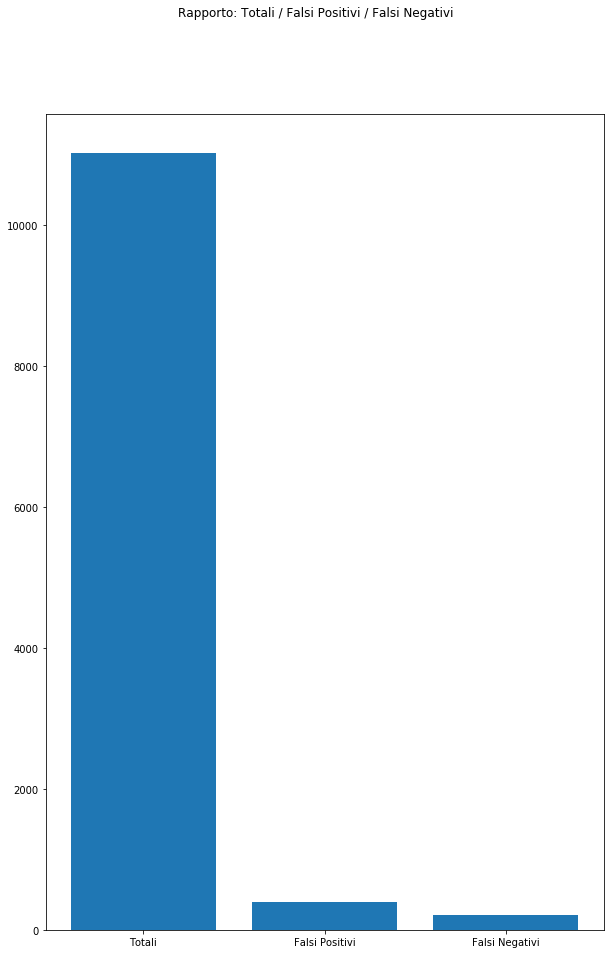

In [47]:
count=0
false_negative = 0
false_positive = 0

if savemod:
    for row in x_validation_dataframe.itertuples(index=True, name='Pandas'):
        img = Image.open(getattr(row, "Filename"))
        label = getattr(row, "Label")
        img = img.convert("RGB")
        img = img.resize((img_width, img_height), Image.ANTIALIAS)
        img = img_to_array(img)
        img = img/255.0
        img = img.reshape((1,) + img.shape)
        pred = model.predict(img)
        pred = pred.item(0)
        pred = np.round(pred, decimals = 3)
        if pred > 0.500 and label == 'Parasitized':
            false_negative = false_negative + 1
        if pred <= 0.500 and label == 'Uninfected':
            false_positive = false_positive + 1
        count=count + 1
        #if count >1000:
        #    break;               
    data = {'Totali' : count, 'Falsi Positivi' : false_positive, 'Falsi Negativi' : false_negative}
    data.to_csv("predicted_data.csv")
else:
    data =  pd.read_csv('p
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 1, figsize=(10, 15), sharey=True)
axs.bar(names, values)
fig.suptitle('Rapporto: Totali / Falsi Positivi / Falsi Negativi')
plt.show()

